In [1]:
!pip install pandas matplotlib seaborn scikit-learn

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_squared_error



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4223 non-null   datetime64[ns]
 1   BC      4223 non-null   float64       
 2   N_CPC   4223 non-null   float64       
 3   PM-10   4223 non-null   float64       
 4   PM-2.5  4223 non-null   float64       
 5   PM-1.0  4223 non-null   float64       
 6   NO2     4223 non-null   float64       
 7   O3      4223 non-null   float64       
 8   SO2     4223 non-null   float64       
 9   CO      4223 non-null   float64       
 10  NO      4223 non-null   float64       
 11  NOX     4223 non-null   float64       
 12  TEMP    4223 non-null   float64       
 13  HUM     4223 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 462.0 KB
None

Basic Statistics:
                                date           BC        N_CPC        PM-10  \
count    

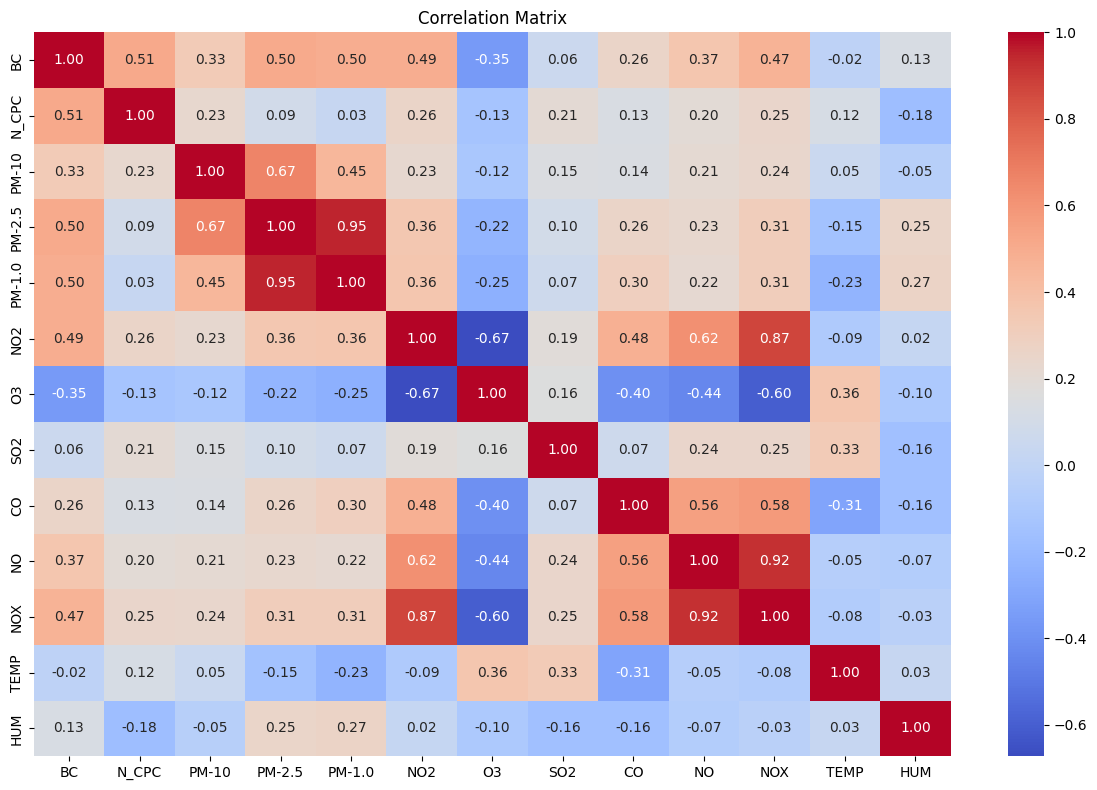

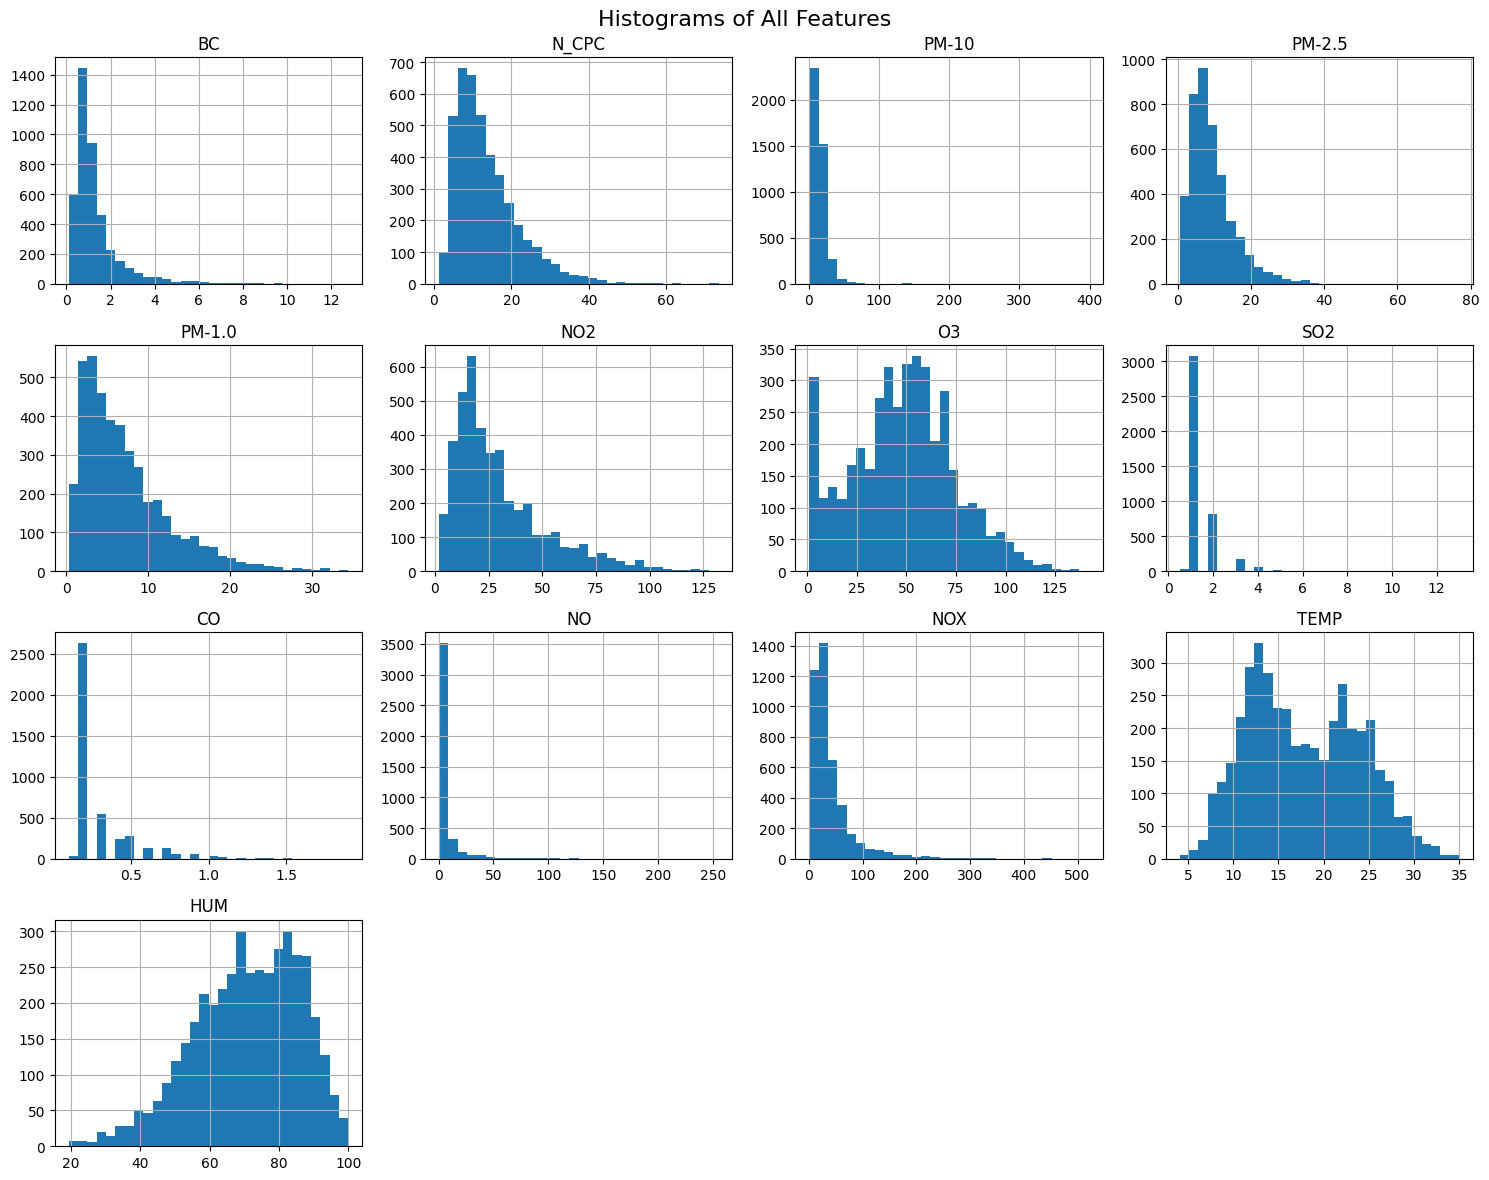

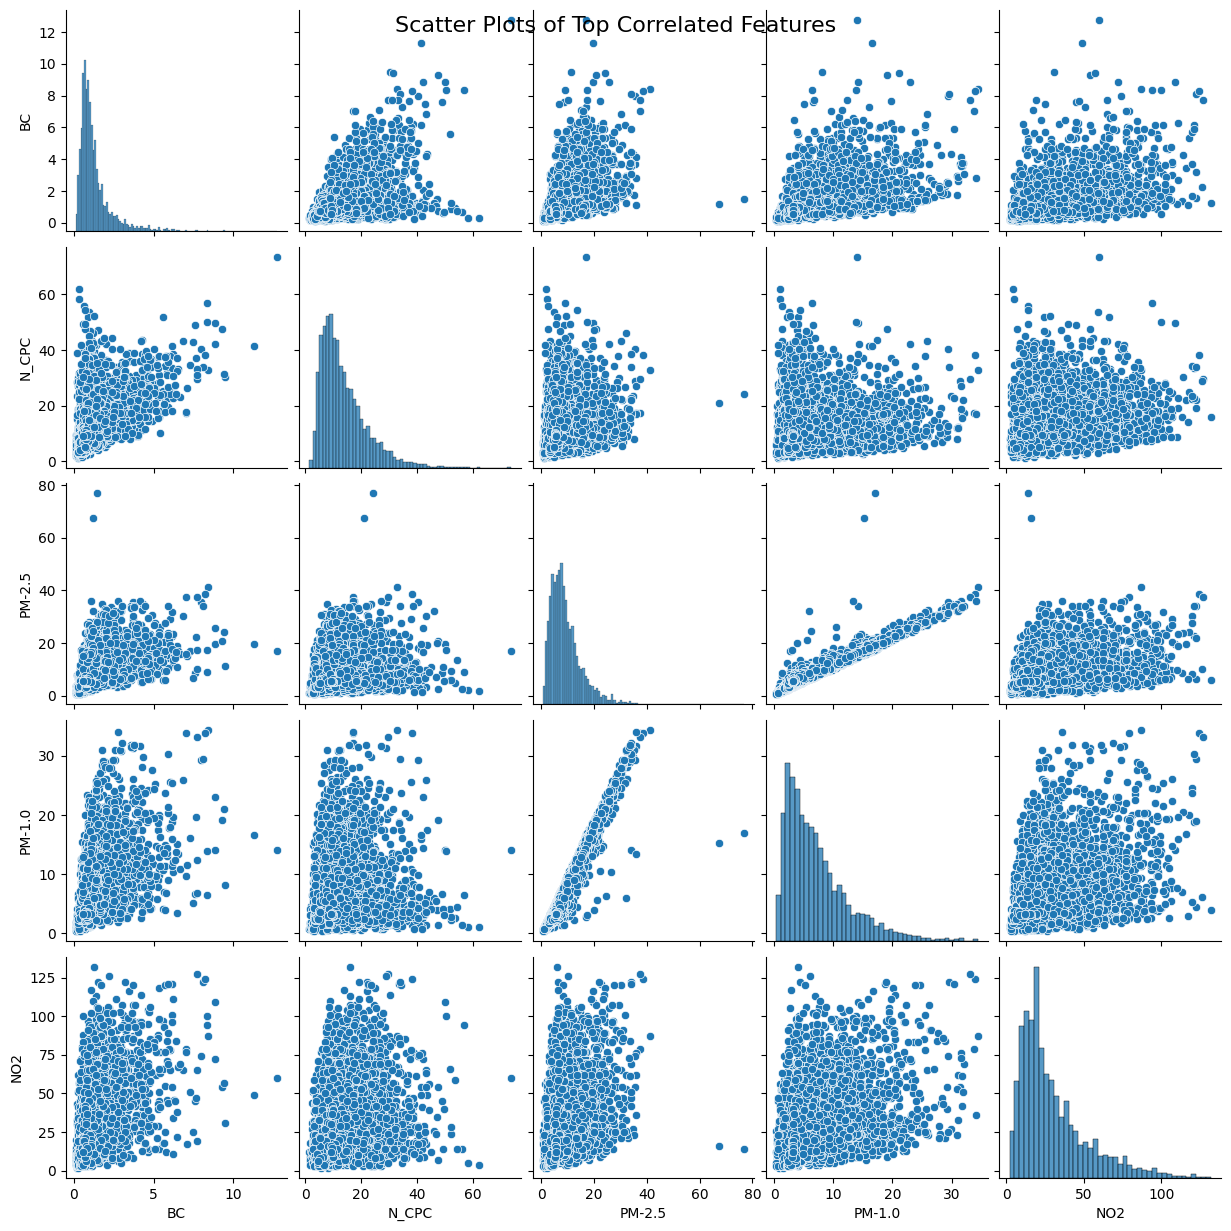

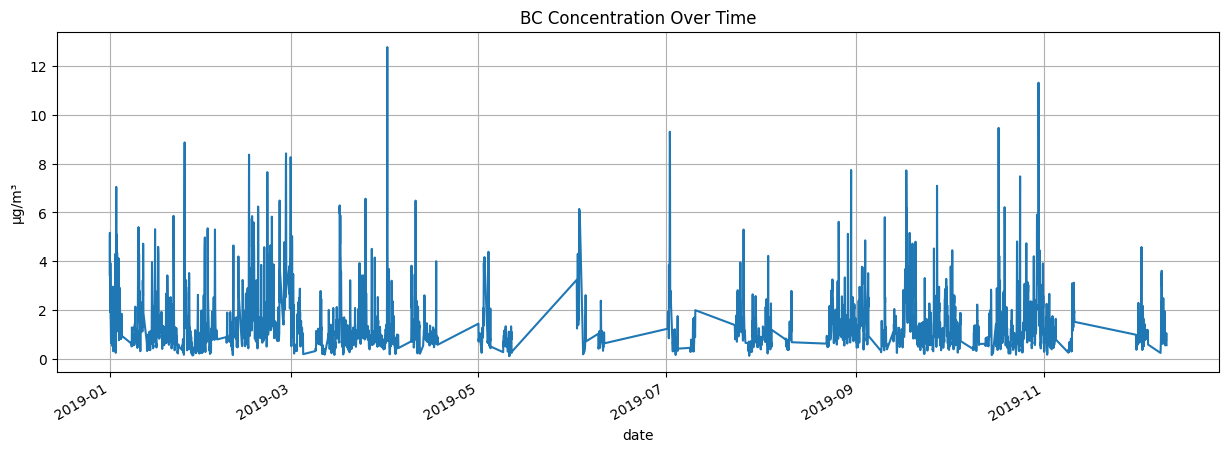

In [7]:
# Load the dataset with proper separator
df = pd.read_csv("BC-Data-Set.csv", sep=';')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Convert numeric columns to float
numeric_columns = ['BC', 'N_CPC', 'PM-10', 'PM-2.5', 'PM-1.0', 'NO2', 'O3', 'SO2', 'CO', 'NO', 'NOX', 'TEMP', 'HUM']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# 1. Basic inspection
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isna().sum())

# 2. Correlation matrix
plt.figure(figsize=(12, 8))
correlation = df[numeric_columns].corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 3. Distribution plots (histograms)
df[numeric_columns].hist(figsize=(15, 12), bins=30)
plt.suptitle("Histograms of All Features", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Pairplot (scatter plots of selected variables vs BC)
top_corr_features = correlation["BC"].drop("BC").abs().sort_values(ascending=False).head(4).index.tolist()
sns.pairplot(df, vars=["BC"] + top_corr_features)
plt.suptitle("Scatter Plots of Top Correlated Features", fontsize=16)
plt.show()

# 5. Temporal trend of BC
plt.figure(figsize=(15, 5))
df.set_index('date')['BC'].plot()
plt.title("BC Concentration Over Time")
plt.ylabel("μg/m³")
plt.grid(True)
plt.show()

In [8]:
# Prepare cleaned data
df_ml = df.dropna(subset=numeric_columns)
X = df_ml.drop(columns=["BC", "date"]).copy()
y = df_ml["BC"]

# Manually select features for log-transformation based on skew, range, or inspection
log_transform_feats = ['N_CPC', 'PM-10', 'PM-2.5', 'PM-1.0', 'NO', 'NOX', 'CO', 'O3', 'SO2']

# Apply log1p to selected features
for col in log_transform_feats:
    if col in X.columns and (X[col] > 0).all():
        X[f"log_{col}"] = np.log1p(X[col])
        X.drop(columns=[col], inplace=True)  # Optionally drop original version to avoid collinearity

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR
svr_full = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_full.fit(X_train_scaled, y_train)
y_pred_full = svr_full.predict(X_test_scaled)

# Evaluate
r2 = r2_score(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

print(f"\nSelective log-transform SVR R^2: {r2:.3f}")
print(f"Selective log-transform SVR RMSE: {rmse:.3f}")


Selective log-transform SVR R^2: 0.743
Selective log-transform SVR RMSE: 0.527


In [9]:
results = []

# Loop through different feature counts
for n in [5, 6, 7, 8, 9, 10]:
    print(f"\nSelecting top {n} features using FSS...")

    # FSS with SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    sfs = SequentialFeatureSelector(svr_model, 
                                    n_features_to_select=n, 
                                    direction='forward', 
                                    scoring='neg_mean_squared_error',
                                    cv=3, n_jobs=-1)
    sfs.fit(X_train_scaled, y_train)

    selected_features = X.columns[sfs.get_support()].tolist()
    print("Selected features:", selected_features)

    # Train and evaluate model on selected features
    X_train_fss = X_train[selected_features]
    X_test_fss = X_test[selected_features]

    scaler_sub = StandardScaler()
    X_train_fss_scaled = scaler_sub.fit_transform(X_train_fss)
    X_test_fss_scaled = scaler_sub.transform(X_test_fss)

    svr_fss = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_fss.fit(X_train_fss_scaled, y_train)
    y_pred_fss = svr_fss.predict(X_test_fss_scaled)

    r2 = r2_score(y_test, y_pred_fss)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_fss))
    
    print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")

    results.append({
        'n_features': n,
        'features': selected_features,
        'R2': r2,
        'RMSE': rmse
    })



Selecting top 5 features using FSS...
Selected features: ['TEMP', 'log_N_CPC', 'log_PM-2.5', 'log_NO', 'log_O3']
R²: 0.719, RMSE: 0.551

Selecting top 6 features using FSS...
Selected features: ['TEMP', 'log_N_CPC', 'log_PM-2.5', 'log_PM-1.0', 'log_NO', 'log_O3']
R²: 0.721, RMSE: 0.549

Selecting top 7 features using FSS...
Selected features: ['TEMP', 'log_N_CPC', 'log_PM-10', 'log_PM-2.5', 'log_PM-1.0', 'log_NO', 'log_O3']
R²: 0.733, RMSE: 0.537

Selecting top 8 features using FSS...
Selected features: ['TEMP', 'HUM', 'log_N_CPC', 'log_PM-10', 'log_PM-2.5', 'log_PM-1.0', 'log_NO', 'log_O3']
R²: 0.738, RMSE: 0.532

Selecting top 9 features using FSS...
Selected features: ['TEMP', 'HUM', 'log_N_CPC', 'log_PM-10', 'log_PM-2.5', 'log_PM-1.0', 'log_NO', 'log_NOX', 'log_O3']
R²: 0.740, RMSE: 0.530

Selecting top 10 features using FSS...
Selected features: ['TEMP', 'HUM', 'log_N_CPC', 'log_PM-10', 'log_PM-2.5', 'log_PM-1.0', 'log_NO', 'log_NOX', 'log_O3', 'log_SO2']
R²: 0.739, RMSE: 0.531


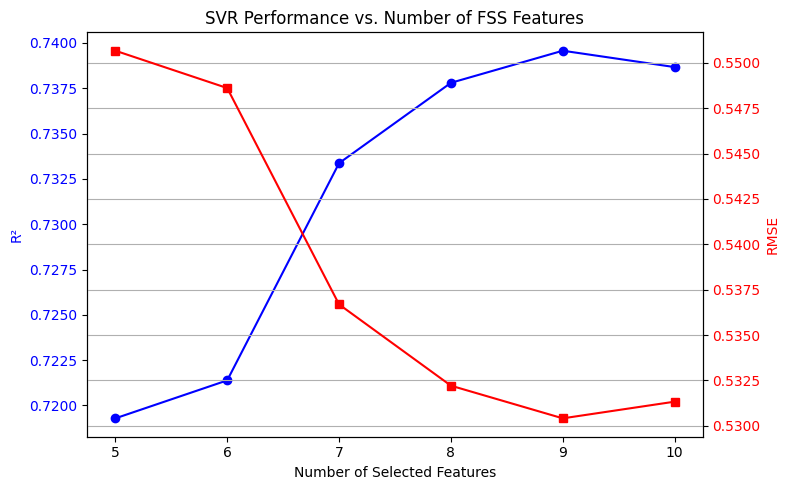

In [10]:
summary_df = pd.DataFrame(results)

fig, ax1 = plt.subplots(figsize=(8, 5))

# R² on left axis
ax1.plot(summary_df['n_features'], summary_df['R2'], marker='o', label='R²', color='blue')
ax1.set_ylabel('R²', color='blue')
ax1.set_xlabel('Number of Selected Features')
ax1.tick_params(axis='y', labelcolor='blue')

# RMSE on right axis
ax2 = ax1.twinx()
ax2.plot(summary_df['n_features'], summary_df['RMSE'], marker='s', label='RMSE', color='red')
ax2.set_ylabel('RMSE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("SVR Performance vs. Number of FSS Features")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
fss_summary = pd.DataFrame(results)
print(fss_summary[['n_features', 'R2', 'RMSE']])

   n_features        R2      RMSE
0           5  0.719289  0.550672
1           6  0.721384  0.548613
2           7  0.733366  0.536686
3           8  0.737799  0.532207
4           9  0.739570  0.530406
5          10  0.738666  0.531325


In [12]:
selected_fss = fss_summary.loc[fss_summary['R2'].idxmax()]['features']
print(f"Best FSS features: {selected_fss}")


Best FSS features: ['TEMP', 'HUM', 'log_N_CPC', 'log_PM-10', 'log_PM-2.5', 'log_PM-1.0', 'log_NO', 'log_NOX', 'log_O3']


In [13]:
# Use FSS-selected features
X_train_fss = X_train[selected_fss]
X_test_fss = X_test[selected_fss]

# Scale again just for selected features
scaler_fss = StandardScaler()
X_train_fss_scaled = scaler_fss.fit_transform(X_train_fss)
X_test_fss_scaled = scaler_fss.transform(X_test_fss)

# Train & Evaluate
svr_fss = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_fss.fit(X_train_fss_scaled, y_train)
y_pred_fss = svr_fss.predict(X_test_fss_scaled)
r2_fss = r2_score(y_test, y_pred_fss)
rmse_fss = np.sqrt(mean_squared_error(y_test, y_pred_fss))
print(f"\nSVR with FSS features R^2: {r2_fss:.3f}")
print(f"SVR with FSS features RMSE: {rmse_fss:.3f}")




SVR with FSS features R^2: 0.740
SVR with FSS features RMSE: 0.530


Best SVR parameters from GridSearchCV:
{'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVR R^2: 0.789
Best SVR RMSE: 0.477


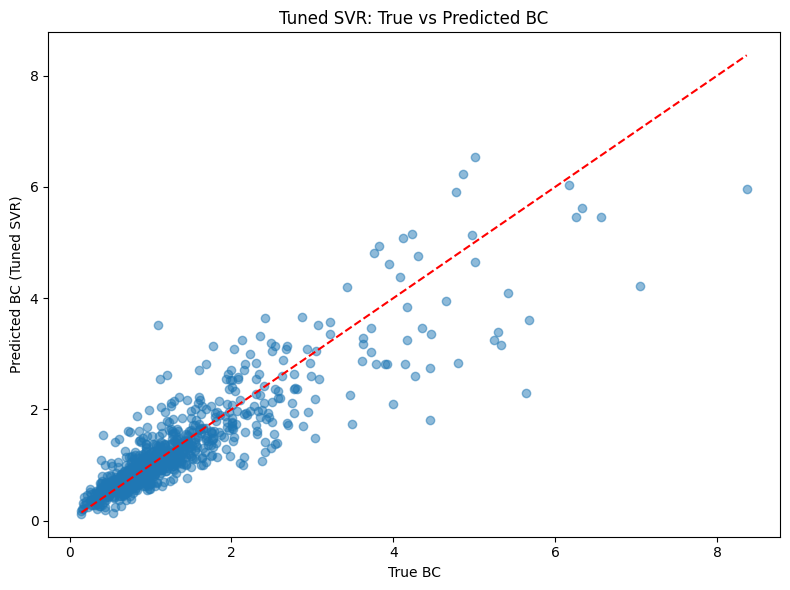

In [14]:
# Grid Search with best features
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_fss_scaled, y_train)

print("Best SVR parameters from GridSearchCV:")
print(grid_search.best_params_)

# Final evaluation
best_svr = grid_search.best_estimator_
y_pred_best = best_svr.predict(X_test_fss_scaled)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Best SVR R^2: {r2_best:.3f}")
print(f"Best SVR RMSE: {rmse_best:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.xlabel("True BC")
plt.ylabel("Predicted BC (Tuned SVR)")
plt.title("Tuned SVR: True vs Predicted BC")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


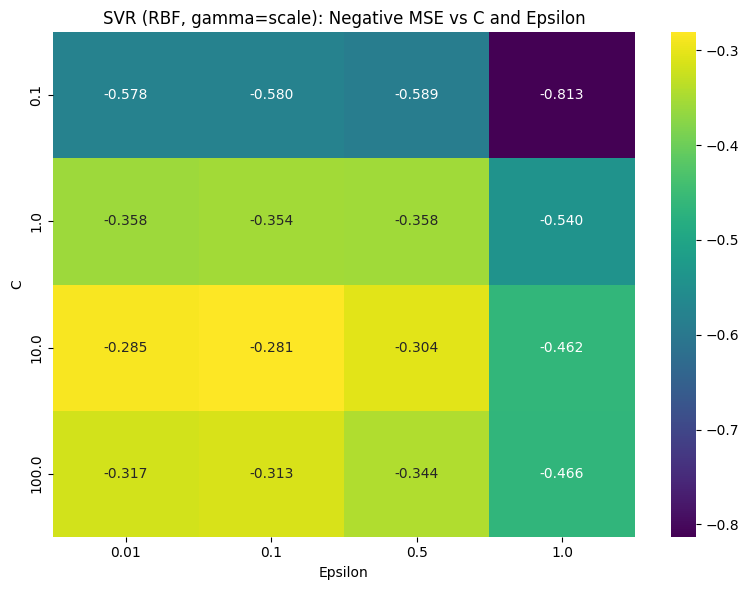

In [15]:
# Convert to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)


# Filter to the same kernel and gamma as best result
filtered_df = results_df[
    (results_df['param_kernel'] == 'rbf') &
    (results_df['param_gamma'] == 'scale')
]

# Pivot only this slice
pivot = filtered_df.pivot_table(
    index='param_C',
    columns='param_epsilon',
    values='mean_test_score',
    aggfunc='mean'
)

# Plot 
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("SVR (RBF, gamma=scale): Negative MSE vs C and Epsilon")
plt.ylabel("C")
plt.xlabel("Epsilon")
plt.tight_layout()
plt.show()


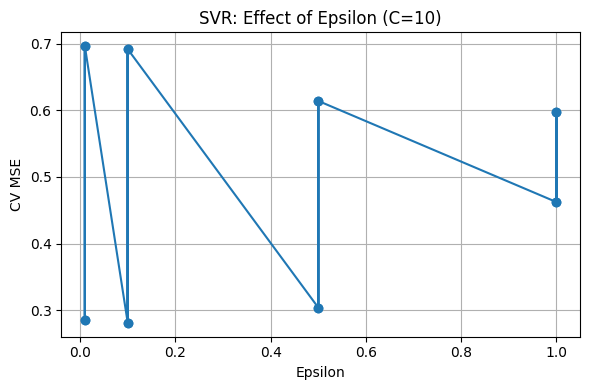

In [17]:
# Line plot: Effect of epsilon for best C
import matplotlib.pyplot as plt

# Filter best C (e.g., C=10 from best_params)
subset = results_df[results_df['param_C'] == 10]

plt.figure(figsize=(6, 4))
plt.plot(subset['param_epsilon'], -subset['mean_test_score'], marker='o')
plt.xlabel("Epsilon")
plt.ylabel("CV MSE")
plt.title("SVR: Effect of Epsilon (C=10)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Full feature set
scaler_lasso = StandardScaler()
X_train_lasso_scaled = scaler_lasso.fit_transform(X_train)
X_test_lasso_scaled = scaler_lasso.transform(X_test)

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_lasso_scaled, y_train)

# 1. Extract selected features from Lasso
lasso_selected_mask = np.abs(lasso_cv.coef_) > 1e-4
selected_lasso = X.columns[lasso_selected_mask].tolist()
print("Lasso-selected features:", selected_lasso)

# 2. Subset data
X_train_lsel = X_train[selected_lasso]
X_test_lsel = X_test[selected_lasso]

# 3. Scale
scaler_lsel = StandardScaler()
X_train_lsel_scaled = scaler_lsel.fit_transform(X_train_lsel)
X_test_lsel_scaled = scaler_lsel.transform(X_test_lsel)

# 4. Train SVR on Lasso-selected features
svr_lsel = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_lsel.fit(X_train_lsel_scaled, y_train)
y_pred_svr_lsel = svr_lsel.predict(X_test_lsel_scaled)

# 5. Evaluate
r2_svr_lsel = r2_score(y_test, y_pred_svr_lsel)
rmse_svr_lsel = np.sqrt(mean_squared_error(y_test, y_pred_svr_lsel))

print(f"\nSVR with Lasso-selected features R^2: {r2_svr_lsel:.3f}")
print(f"SVR with Lasso-selected features RMSE: {rmse_svr_lsel:.3f}")

Lasso-selected features: ['NO2', 'TEMP', 'HUM', 'log_N_CPC', 'log_PM-10', 'log_PM-2.5', 'log_PM-1.0', 'log_NO', 'log_NOX', 'log_CO', 'log_O3', 'log_SO2']

SVR with Lasso-selected features R^2: 0.743
SVR with Lasso-selected features RMSE: 0.527


In [13]:
summary = pd.DataFrame({
    'Model': ['Full Features', 'SVR (FSS)', 'SVR (Lasso)', 'SVR (FSS & Tuned)'],
    'R2': [r2, r2_fss, r2_svr_lsel, r2_best],
    'RMSE': [rmse, rmse_fss, rmse_svr_lsel, rmse_best]
})
print(summary)


               Model        R2      RMSE
0      Full Features  0.738666  0.531325
1          SVR (FSS)  0.739570  0.530406
2        SVR (Lasso)  0.742777  0.527130
3  SVR (FSS & Tuned)  0.789127  0.477281


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Use FSS-selected features
X_train_rf = X_train[selected_fss]
X_test_rf = X_test[selected_fss]

# Standardize
scaler_rf = StandardScaler()
X_train_rf_scaled = scaler_rf.fit_transform(X_train_rf)
X_test_rf_scaled = scaler_rf.transform(X_test_rf)

# Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_rf_scaled, y_train)
y_pred_rf = rf.predict(X_test_rf_scaled)

# Evaluate
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"\nRandom Forest (FSS features) R^2: {r2_rf:.3f}")
print(f"Random Forest (FSS features) RMSE: {rmse_rf:.3f}")



Random Forest (FSS features) R^2: 0.677
Random Forest (FSS features) RMSE: 0.591


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_rf_scaled, y_train)
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_rf_scaled)

r2_best_rf = r2_score(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))

print("\nBest RF Parameters:", grid_rf.best_params_)
print(f"Best RF R^2: {r2_best_rf:.3f}")
print(f"Best RF RMSE: {rmse_best_rf:.3f}")


Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best RF Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best RF R^2: 0.690
Best RF RMSE: 0.579


In [16]:
summary.loc[len(summary)] = ['Random Forest (FSS)', r2_rf, rmse_rf]
summary.loc[len(summary)] = ['Random Forest (FSS & Tuned)', r2_best_rf, rmse_best_rf]
print(summary)


                         Model        R2      RMSE
0                Full Features  0.738666  0.531325
1                    SVR (FSS)  0.739570  0.530406
2                  SVR (Lasso)  0.742777  0.527130
3            SVR (FSS & Tuned)  0.789127  0.477281
4          Random Forest (FSS)  0.676829  0.590853
5  Random Forest (FSS & Tuned)  0.690163  0.578535


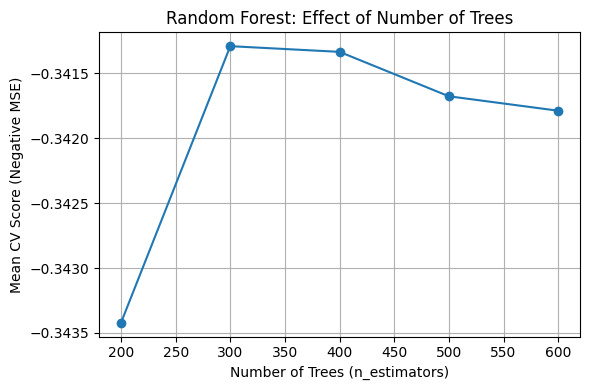

In [17]:
# Convert GridSearchCV results to DataFrame
results_rf = pd.DataFrame(grid_rf.cv_results_)

# Group by n_estimators
grouped_rf = results_rf.groupby('param_n_estimators')['mean_test_score'].mean()

# Plot
plt.figure(figsize=(6, 4))
grouped_rf.plot(marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean CV Score (Negative MSE)")
plt.title("Random Forest: Effect of Number of Trees")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Use FSS-selected features
X_train_gb = X_train[selected_fss]
X_test_gb = X_test[selected_fss]

# Standardize (optional for tree-based models, but for consistency)
scaler_gb = StandardScaler()
X_train_gb_scaled = scaler_gb.fit_transform(X_train_gb)
X_test_gb_scaled = scaler_gb.transform(X_test_gb)

# Train Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_gb_scaled, y_train)
y_pred_gb = gb.predict(X_test_gb_scaled)

# Evaluate
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f"\nGradient Boosting (FSS) R^2: {r2_gb:.3f}")
print(f"Gradient Boosting (FSS) RMSE: {rmse_gb:.3f}")



Gradient Boosting (FSS) R^2: 0.694
Gradient Boosting (FSS) RMSE: 0.575


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2]
}

grid_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train_gb_scaled, y_train)
best_gb = grid_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_test_gb_scaled)

r2_best_gb = r2_score(y_test, y_pred_best_gb)
rmse_best_gb = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))

print("\nBest GB Parameters:", grid_gb.best_params_)
print(f"Best GB R^2: {r2_best_gb:.3f}")
print(f"Best GB RMSE: {rmse_best_gb:.3f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best GB Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200}
Best GB R^2: 0.730
Best GB RMSE: 0.540


In [20]:
summary.loc[len(summary)] = ['Gradient Boosting (FSS)', r2_gb, rmse_gb]
summary.loc[len(summary)] = ['Gradient Boosting (FSS & Tuned)', r2_best_gb, rmse_best_gb]
print(summary)


                             Model        R2      RMSE
0                    Full Features  0.738666  0.531325
1                        SVR (FSS)  0.739570  0.530406
2                      SVR (Lasso)  0.742777  0.527130
3                SVR (FSS & Tuned)  0.789127  0.477281
4              Random Forest (FSS)  0.676829  0.590853
5      Random Forest (FSS & Tuned)  0.690163  0.578535
6          Gradient Boosting (FSS)  0.693553  0.575361
7  Gradient Boosting (FSS & Tuned)  0.730316  0.539747


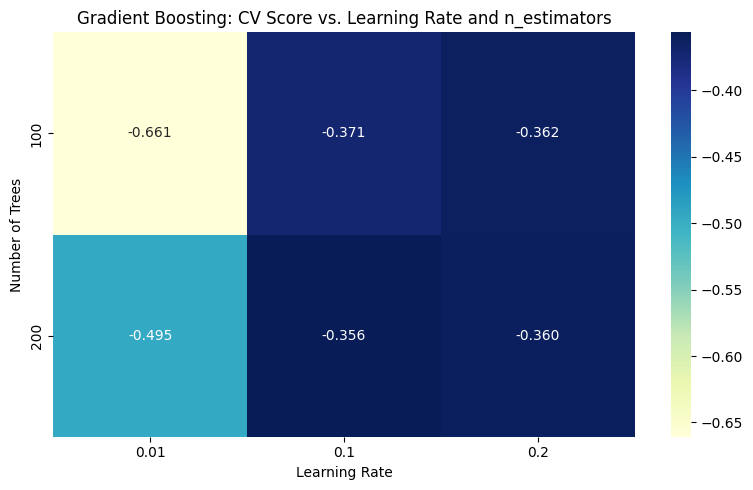

In [21]:
# Convert to DataFrame
results_gb = pd.DataFrame(grid_gb.cv_results_)

# Pivot to heatmap format
pivot = results_gb.pivot_table(
    index='param_n_estimators',
    columns='param_learning_rate',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Gradient Boosting: CV Score vs. Learning Rate and n_estimators")
plt.xlabel("Learning Rate")
plt.ylabel("Number of Trees")
plt.tight_layout()
plt.show()


In [22]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Use FSS-selected features
X_train_nn = X_train[selected_fss]
X_test_nn = X_test[selected_fss]

# Scale features (very important for FFNNs!)
scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

# Train FFNN model
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    early_stopping=True,
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train_nn_scaled, y_train)
y_pred_nn = mlp.predict(X_test_nn_scaled)

# Evaluate
r2_nn = r2_score(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))

print(f"\nFFNN (FSS) R^2: {r2_nn:.3f}")
print(f"FFNN (FSS) RMSE: {rmse_nn:.3f}")



FFNN (FSS) R^2: 0.796
FFNN (FSS) RMSE: 0.469


In [36]:
from sklearn.model_selection import GridSearchCV

param_grid_nn = {
    'hidden_layer_sizes': [(64,), (100,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}

grid_nn = GridSearchCV(
    MLPRegressor(max_iter=1000, random_state=42, early_stopping=True),
    param_grid_nn,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_nn.fit(X_train_nn_scaled, y_train)
best_nn = grid_nn.best_estimator_
y_pred_best_nn = best_nn.predict(X_test_nn_scaled)

r2_best_nn = r2_score(y_test, y_pred_best_nn)
rmse_best_nn = np.sqrt(mean_squared_error(y_test, y_pred_best_nn))

print("\nBest FFNN Parameters:", grid_nn.best_params_)
print(f"Best FFNN R^2: {r2_best_nn:.3f}")
print(f"Best FFNN RMSE: {rmse_best_nn:.3f}")


Fitting 3 folds for each of 96 candidates, totalling 288 fits


/Users/ezgisenakarabacak/UPC/TOML/TOML_HW2/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ezgisenakarabacak/UPC/TOML/TOML_HW2/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ezgisenakarabacak/UPC/TOML/TOML_HW2/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Best FFNN Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01, 'solver': 'adam'}
Best FFNN R^2: 0.787
Best FFNN RMSE: 0.479


/Users/ezgisenakarabacak/UPC/TOML/TOML_HW2/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ezgisenakarabacak/UPC/TOML/TOML_HW2/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ezgisenakarabacak/UPC/TOML/TOML_HW2/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ezgisenakarabacak/UPC/TOML/TOML_HW2/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) 

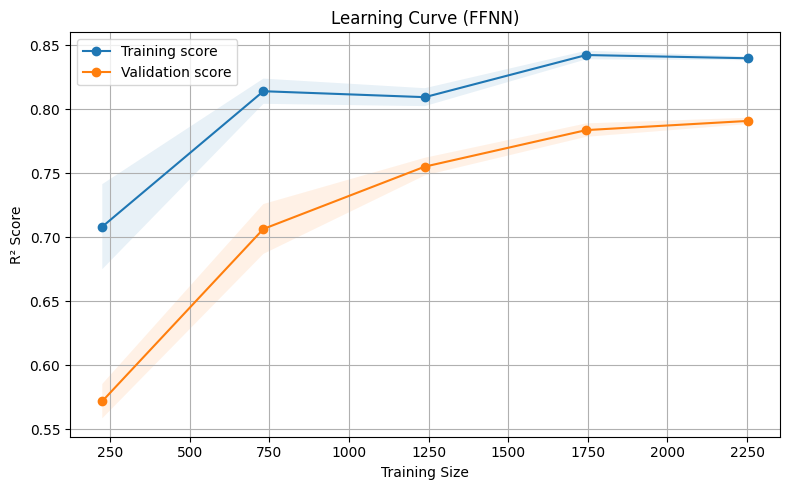

In [24]:

from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    best_nn, X_train_nn_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3, scoring='r2'
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Validation score")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1)
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.1)

plt.title("Learning Curve (FFNN)")
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
summary.loc[len(summary)] = ['FFNN (FSS)', r2_nn, rmse_nn]
summary.loc[len(summary)] = ['FFNN (FSS & Tuned)', r2_best_nn, rmse_best_nn]
print(summary)


                             Model        R2      RMSE
0                    Full Features  0.738666  0.531325
1                        SVR (FSS)  0.739570  0.530406
2                      SVR (Lasso)  0.742777  0.527130
3                SVR (FSS & Tuned)  0.789127  0.477281
4              Random Forest (FSS)  0.676829  0.590853
5      Random Forest (FSS & Tuned)  0.690163  0.578535
6          Gradient Boosting (FSS)  0.693553  0.575361
7  Gradient Boosting (FSS & Tuned)  0.730316  0.539747
8                       FFNN (FSS)  0.796448  0.468922
9               FFNN (FSS & Tuned)  0.783437  0.483677


In [26]:
print("Best CV score:", grid_nn.best_score_)
print("Test R2 score:", r2_best_nn)


Best CV score: -0.27259307920097076
Test R2 score: 0.7834367974766866


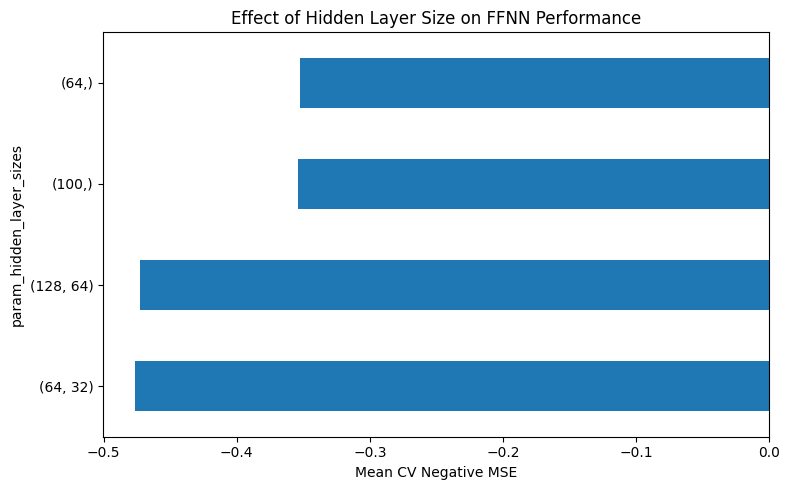

In [27]:
# Convert GridSearchCV results into a DataFrame
results_df = pd.DataFrame(grid_nn.cv_results_)

# Group by hidden layer size and get mean test score (neg MSE)
grouped = results_df.groupby('param_hidden_layer_sizes')['mean_test_score'].mean().sort_values()

# Plot
plt.figure(figsize=(8, 5))
grouped.plot(kind='barh')
plt.xlabel("Mean CV Negative MSE")
plt.title("Effect of Hidden Layer Size on FFNN Performance")
plt.tight_layout()
plt.show()

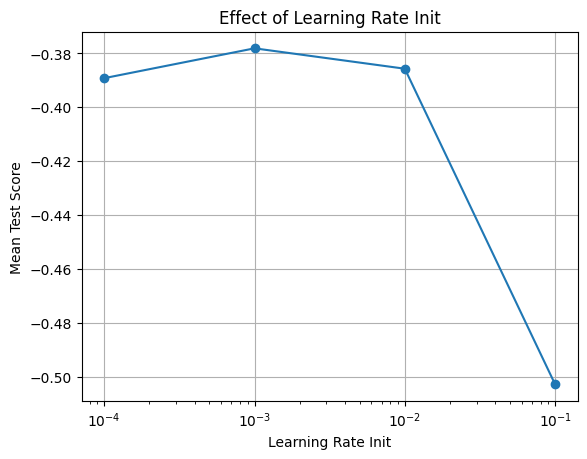

In [34]:
results_df.groupby('param_learning_rate_init')['mean_test_score'].mean().plot(marker='o')
plt.xscale('log')  # Make x-axis log scale
plt.title("Effect of Learning Rate Init")
plt.xlabel("Learning Rate Init")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.show()

In [29]:
# Split data (non-shuffled, time-aware)
X_train_ns = X.iloc[:int(0.8*len(X))]
X_test_ns = X.iloc[int(0.8*len(X)):]
y_train_ns = y.iloc[:int(0.8*len(y))]
y_test_ns = y.iloc[int(0.8*len(y)):]

# Scale
scaler_ns = StandardScaler()
X_train_ns_scaled = scaler_ns.fit_transform(X_train_ns)
X_test_ns_scaled = scaler_ns.transform(X_test_ns)

# Train best FFNN on non-shuffled data
from sklearn.neural_network import MLPRegressor
best_nn_ns = MLPRegressor(**grid_nn.best_params_, max_iter=1000, random_state=42)
best_nn_ns.fit(X_train_ns_scaled, y_train_ns)

# Predict
y_pred_ns = best_nn_ns.predict(X_test_ns_scaled)

# Evaluate
r2_ns = r2_score(y_test_ns, y_pred_ns)
rmse_ns = np.sqrt(mean_squared_error(y_test_ns, y_pred_ns))

print(f"\nNon-Shuffled FFNN R^2: {r2_ns:.3f}")
print(f"Non-Shuffled FFNN RMSE: {rmse_ns:.3f}")



Non-Shuffled FFNN R^2: 0.739
Non-Shuffled FFNN RMSE: 0.571


In [30]:
summary.loc[len(summary)] = ['FFNN & Non-Shuffled)', r2_ns, rmse_ns]
print(summary)

                              Model        R2      RMSE
0                     Full Features  0.738666  0.531325
1                         SVR (FSS)  0.739570  0.530406
2                       SVR (Lasso)  0.742777  0.527130
3                 SVR (FSS & Tuned)  0.789127  0.477281
4               Random Forest (FSS)  0.676829  0.590853
5       Random Forest (FSS & Tuned)  0.690163  0.578535
6           Gradient Boosting (FSS)  0.693553  0.575361
7   Gradient Boosting (FSS & Tuned)  0.730316  0.539747
8                        FFNN (FSS)  0.796448  0.468922
9                FFNN (FSS & Tuned)  0.783437  0.483677
10             FFNN & Non-Shuffled)  0.739454  0.570896


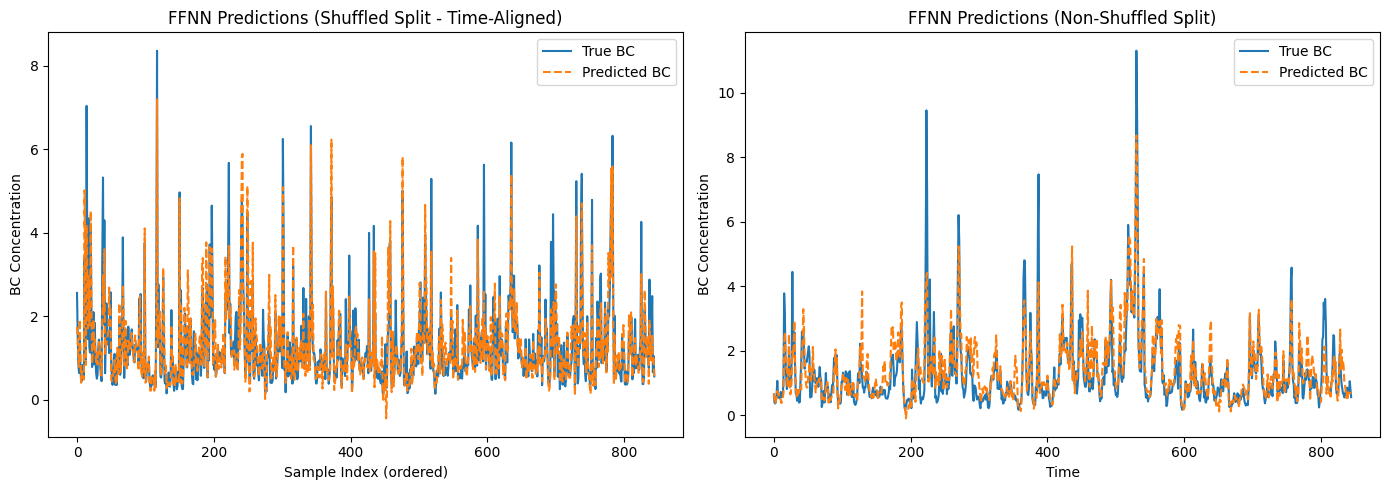

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14, 5))

# 🟦 1. Shuffled data (recover temporal order by index)
plt.subplot(1, 2, 1)
shuffled_order = y_test.sort_index()
sorted_preds = pd.Series(y_pred_best_nn, index=y_test.index).loc[shuffled_order.index]

plt.plot(shuffled_order.values, label="True BC")
plt.plot(sorted_preds.values, label="Predicted BC", linestyle='--')
plt.title("FFNN Predictions (Shuffled Split - Time-Aligned)")
plt.xlabel("Sample Index (ordered)")
plt.ylabel("BC Concentration")
plt.legend()

# 🟧 2. Non-shuffled data (already ordered)
plt.subplot(1, 2, 2)
plt.plot(y_test_ns.values, label="True BC")
plt.plot(y_pred_ns, label="Predicted BC", linestyle='--')
plt.title("FFNN Predictions (Non-Shuffled Split)")
plt.xlabel("Time")
plt.ylabel("BC Concentration")
plt.legend()

plt.tight_layout()
plt.show()